In [1]:
import numpy as np                                                                                          ###
import pandas as pd
import matplotlib.pyplot as plt   
from scipy.interpolate import interp1d

In [2]:
NLinFile=input("Enter the Name of the Nonlinear Curve Data File to be Read: ")
f=pd.read_excel(NLinFile + ".xlsx", header=None)
Disp=f[0].tolist()
Force = f[1].tolist()
AreaFD = []
for i in range(len(Force)):
    if i>0:
        area = ((Force[i]+Force[i-1])/2)*(Disp[i]-Disp[i-1])
        AreaFD.append(area)
Energy = sum(AreaFD)

Enter the Name of the Nonlinear Curve Data File to be Read: PushoverCurve


In [3]:
tol = 1   # This value can be decided by the user. Lower is better.

MaxForceRatio = 0.98      # This value can be decided by the user
if Force[-1]/max(Force)<0.80:
    UltimateForceRatio = 0.80
else:
    UltimateForceRatio = MaxForceRatio

Linearforceratio = 0.15        # It assumes that initial slope remains same upto 15% of the maximum force.
                                # It can be increased by the user if the initial portion of the curve is linear

Disp_sl_initial=np.interp(Linearforceratio*max(Force),Force,Disp)
Disp_sl_final=np.interp(UltimateForceRatio*max(Force),Force,Disp)
Sl_initial = (Linearforceratio*max(Force)-Force[0])/(Disp_sl_initial-Disp[0]) # Assumed initial Slope
Sl_final = (UltimateForceRatio*max(Force)-Force[0])/(Disp_sl_final-Disp[0]) # Assumed Final Slope

In [4]:
#Selecting first and Last points
F1=Force[0]; D1=Disp[0] #First point
F3=UltimateForceRatio*max(Force); D3 = max(Disp) # Last Point

slope_interval = 0.002   #This value can be decided by the user. Lower is better.
Slr=list(np.arange(Sl_final,Sl_initial,slope_interval))
Fr=list(np.arange(Linearforceratio*max(Force),UltimateForceRatio*max(Force),1))
Fr.insert(len(Fr), UltimateForceRatio*max(Force))
Slr.insert(len(Slr), Sl_initial)

In [5]:
# Determining all possible bilinear combinations
D2 =[]; F2 =[]; Slr2 =[];
for slr in Slr:
    for fr in Fr:
        f2 = fr
        d2 = ((f2-F1)/slr)+D1
        Energy_equi = (f2+F1)*(d2-D1)/2+(F3+f2)*(D3-d2)/2
        if abs(Energy-Energy_equi)<tol:
            print("Condition Satisfied")
            D2.append(d2)
            F2.append(f2)
            Slr2.append(slr)
            break
        else:
            pass

In [6]:
#Possible Combinations obtained after bilinearization
PP = []
for i in range(len(D2)):
    Displ = [D1, D2[i], D3]
    Forces = [F1, F2[i], F3]
    pp = [Displ, Forces]
    PP.append(pp)

In [7]:
# Determining intersection force to yield force ratio
F_Ratio = []     #It records the ratio of the force corresponding to the intersection of initial slope line with the to the yield force 
                # slope close to the ratio of 0.6 will be finalized
F_Ratio_tol = []
for i in range(len(PP)): 
    y_interp = interp1d(PP[i][0], PP[i][1])   # This interpolates the force in the bilinearised curve corresponding to the original Disp range vlues. 
    Force_intpol =[]
    for ele in Disp:
        force_intpl = float(y_interp(ele))
        Force_intpol.append(force_intpl)
    idx = np.argwhere(np.diff(np.sign(np.array(Force)- np.array(Force_intpol)))).flatten()
    Intersection_Force = Force[idx[1]]
    f_ratio = Force[idx[1]]/PP[i][1][1]
    f_r_tol = abs(0.6-Force[idx[1]]/PP[i][1][1])
    F_Ratio.append(f_ratio)
    F_Ratio_tol.append(f_r_tol)

In [8]:
# It identifies the index of bilinear curve out of all possible combinations for intersection to yield value is close to 0.6
bilin_Combination_indx=pd.Series(F_Ratio_tol).idxmin()

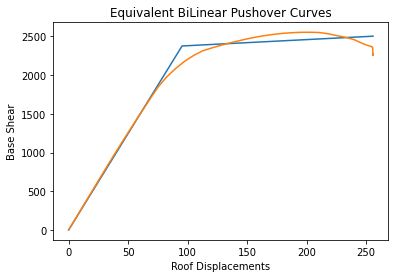

intersection force to yield force ratio: 0.6299901610093066


In [9]:
# Finalized Bilinear Curve:
Disp_bilin_curve = PP[bilin_Combination_indx][0]
Force_bilin_curve = PP[bilin_Combination_indx][1]

# Ploting bilinear and original curves 
plt.plot(Disp_bilin_curve, Force_bilin_curve)
plt.plot(Disp, Force)
plt.xlabel("Roof Displacements")
plt.ylabel("Base Shear")
plt.title("Equivalent BiLinear Pushover Curves")
plt.show()
print("intersection force to yield force ratio:", F_Ratio[bilin_Combination_indx])